<a href="https://colab.research.google.com/github/sneha3322/Detecting-water-bodies-in-satellite-images/blob/main/dip_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

# Define the path to the uploaded zip file
zip_file_path = "/content/archive (1).zip"  # Replace with the actual zip file name

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("/content/images_folder")  # Specify the target folder

# Verify the extracted files
os.listdir("/content/images_folder")


['Water Bodies Dataset']

## **Importing Libraries**

In [ ]:
# Import required libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import random


## **Setting Up Paths**

In [ ]:
# Set paths for water body dataset
train_images_path = "/content/images_folder/Water Bodies Dataset/Images"
train_masks_path = "/content/images_folder/Water Bodies Dataset/Masks"


# **Data Preprocessing Functions and Loading the Dataset**

In [ ]:
# Data Preprocessing
def preprocess_image(img_path, img_size=(128, 128)):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, img_size)
    img = img / 255.0  # Normalize to [0, 1]
    return img

def preprocess_mask(mask_path, img_size=(128, 128)):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, img_size)
    mask = np.where(mask > 127, 1, 0)  # Binarize mask
    return np.expand_dims(mask, axis=-1)

# Load images and masks
def load_data(img_dir, mask_dir, img_size=(128, 128)):
    images, masks = [], []
    for img_file in os.listdir(img_dir):
        images.append(preprocess_image(os.path.join(img_dir, img_file), img_size))
        masks.append(preprocess_mask(os.path.join(mask_dir, img_file), img_size))
    return np.array(images), np.array(masks)

# Load dataset and split into train/test sets
X, Y = load_data(train_images_path, train_masks_path)
split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
Y_train, Y_test = Y[:split_index], Y[split_index:]


## **U-Net Model Architecture**

In [ ]:
# U-Net Architecture
def unet(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    # Bottleneck
    bn = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    bn = Conv2D(256, (3, 3), activation='relu', padding='same')(bn)

    # Decoder
    u1 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn)
    u1 = concatenate([u1, c2])
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(u1)
    c3 = Conv2D(128, (3, 3), activation='relu', padding='same')(c3)

    u2 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u2 = concatenate([u2, c1])
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(u2)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same')(c4)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c4)

    model = Model(inputs, outputs)
    return model


##**Model Compilation and Training**

In [ ]:
# Compile the model
model = unet()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", MeanIoU(num_classes=2)])

# Training
history = model.fit(
    X_train, Y_train,
    validation_split=0.2,
    epochs=80,
    batch_size=16,
)


Epoch 1/80
114/114 ━━━━━━━━━━━━━━━━━━━━ 57s 326ms/step - accuracy: 0.7220 - loss: 0.5634 - mean_io_u: 0.3393 - val_accuracy: 0.7849 - val_loss: 0.4568 - val_mean_io_u: 0.3343
Epoch 2/80
114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 128ms/step - accuracy: 0.7955 - loss: 0.4593 - mean_io_u: 0.3344 - val_accuracy: 0.8120 - val_loss: 0.4500 - val_mean_io_u: 0.3934
Epoch 3/80
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 130ms/step - accuracy: 0.8113 - loss: 0.4420 - mean_io_u: 0.3455 - val_accuracy: 0.8265 - val_loss: 0.3959 - val_mean_io_u: 0.3343
Epoch 4/80
114/114 ━━━━━━━━━━━━━━━━━━━━ 21s 131ms/step - accuracy: 0.8279 - loss: 0.4104 - mean_io_u: 0.3371 - val_accuracy: 0.8359 - val_loss: 0.3986 - val_mean_io_u: 0.3345
Epoch 5/80
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.8449 - loss: 0.3839 - mean_io_u: 0.3349 - val_accuracy: 0.8583 - val_loss: 0.3454 - val_mean_io_u: 0.3343
Epoch 6/80
114/114 ━━━━━━━━━━━━━━━━━━━━ 20s 128ms/step - accuracy: 0.8529 - loss: 0.3627 - mean_io_u: 0.3428 - val_accuracy: 

## **Evaluating the Mode**

In [ ]:
# Evaluate on test set
test_loss, test_accuracy, test_miou = model.evaluate(X_test, Y_test)
print(f"Test Accuracy: {test_accuracy}")
print(f"Mean IoU on Test Set: {test_miou}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8898 - loss: 0.3131 - mean_io_u_1: 0.3634
Test Accuracy: 0.8932152986526489
Mean IoU on Test Set: 0.3672572076320648


## **Plotting Training Metrics**

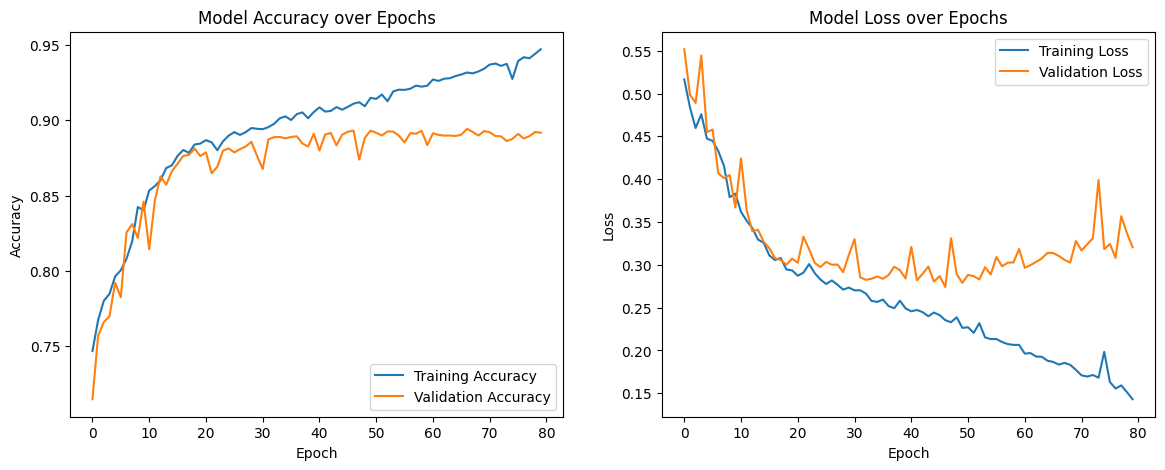

In [ ]:
# Plot Accuracy and Loss over Epochs
def plot_training_history(history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.show()

# Call the function to plot the graphs
plot_training_history(history)


## **Saving the Trained Model**

In [ ]:
# Save Model
model.save("U-Net_water_body_segmentation_model.h5")


## **Visualizing Predictions**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


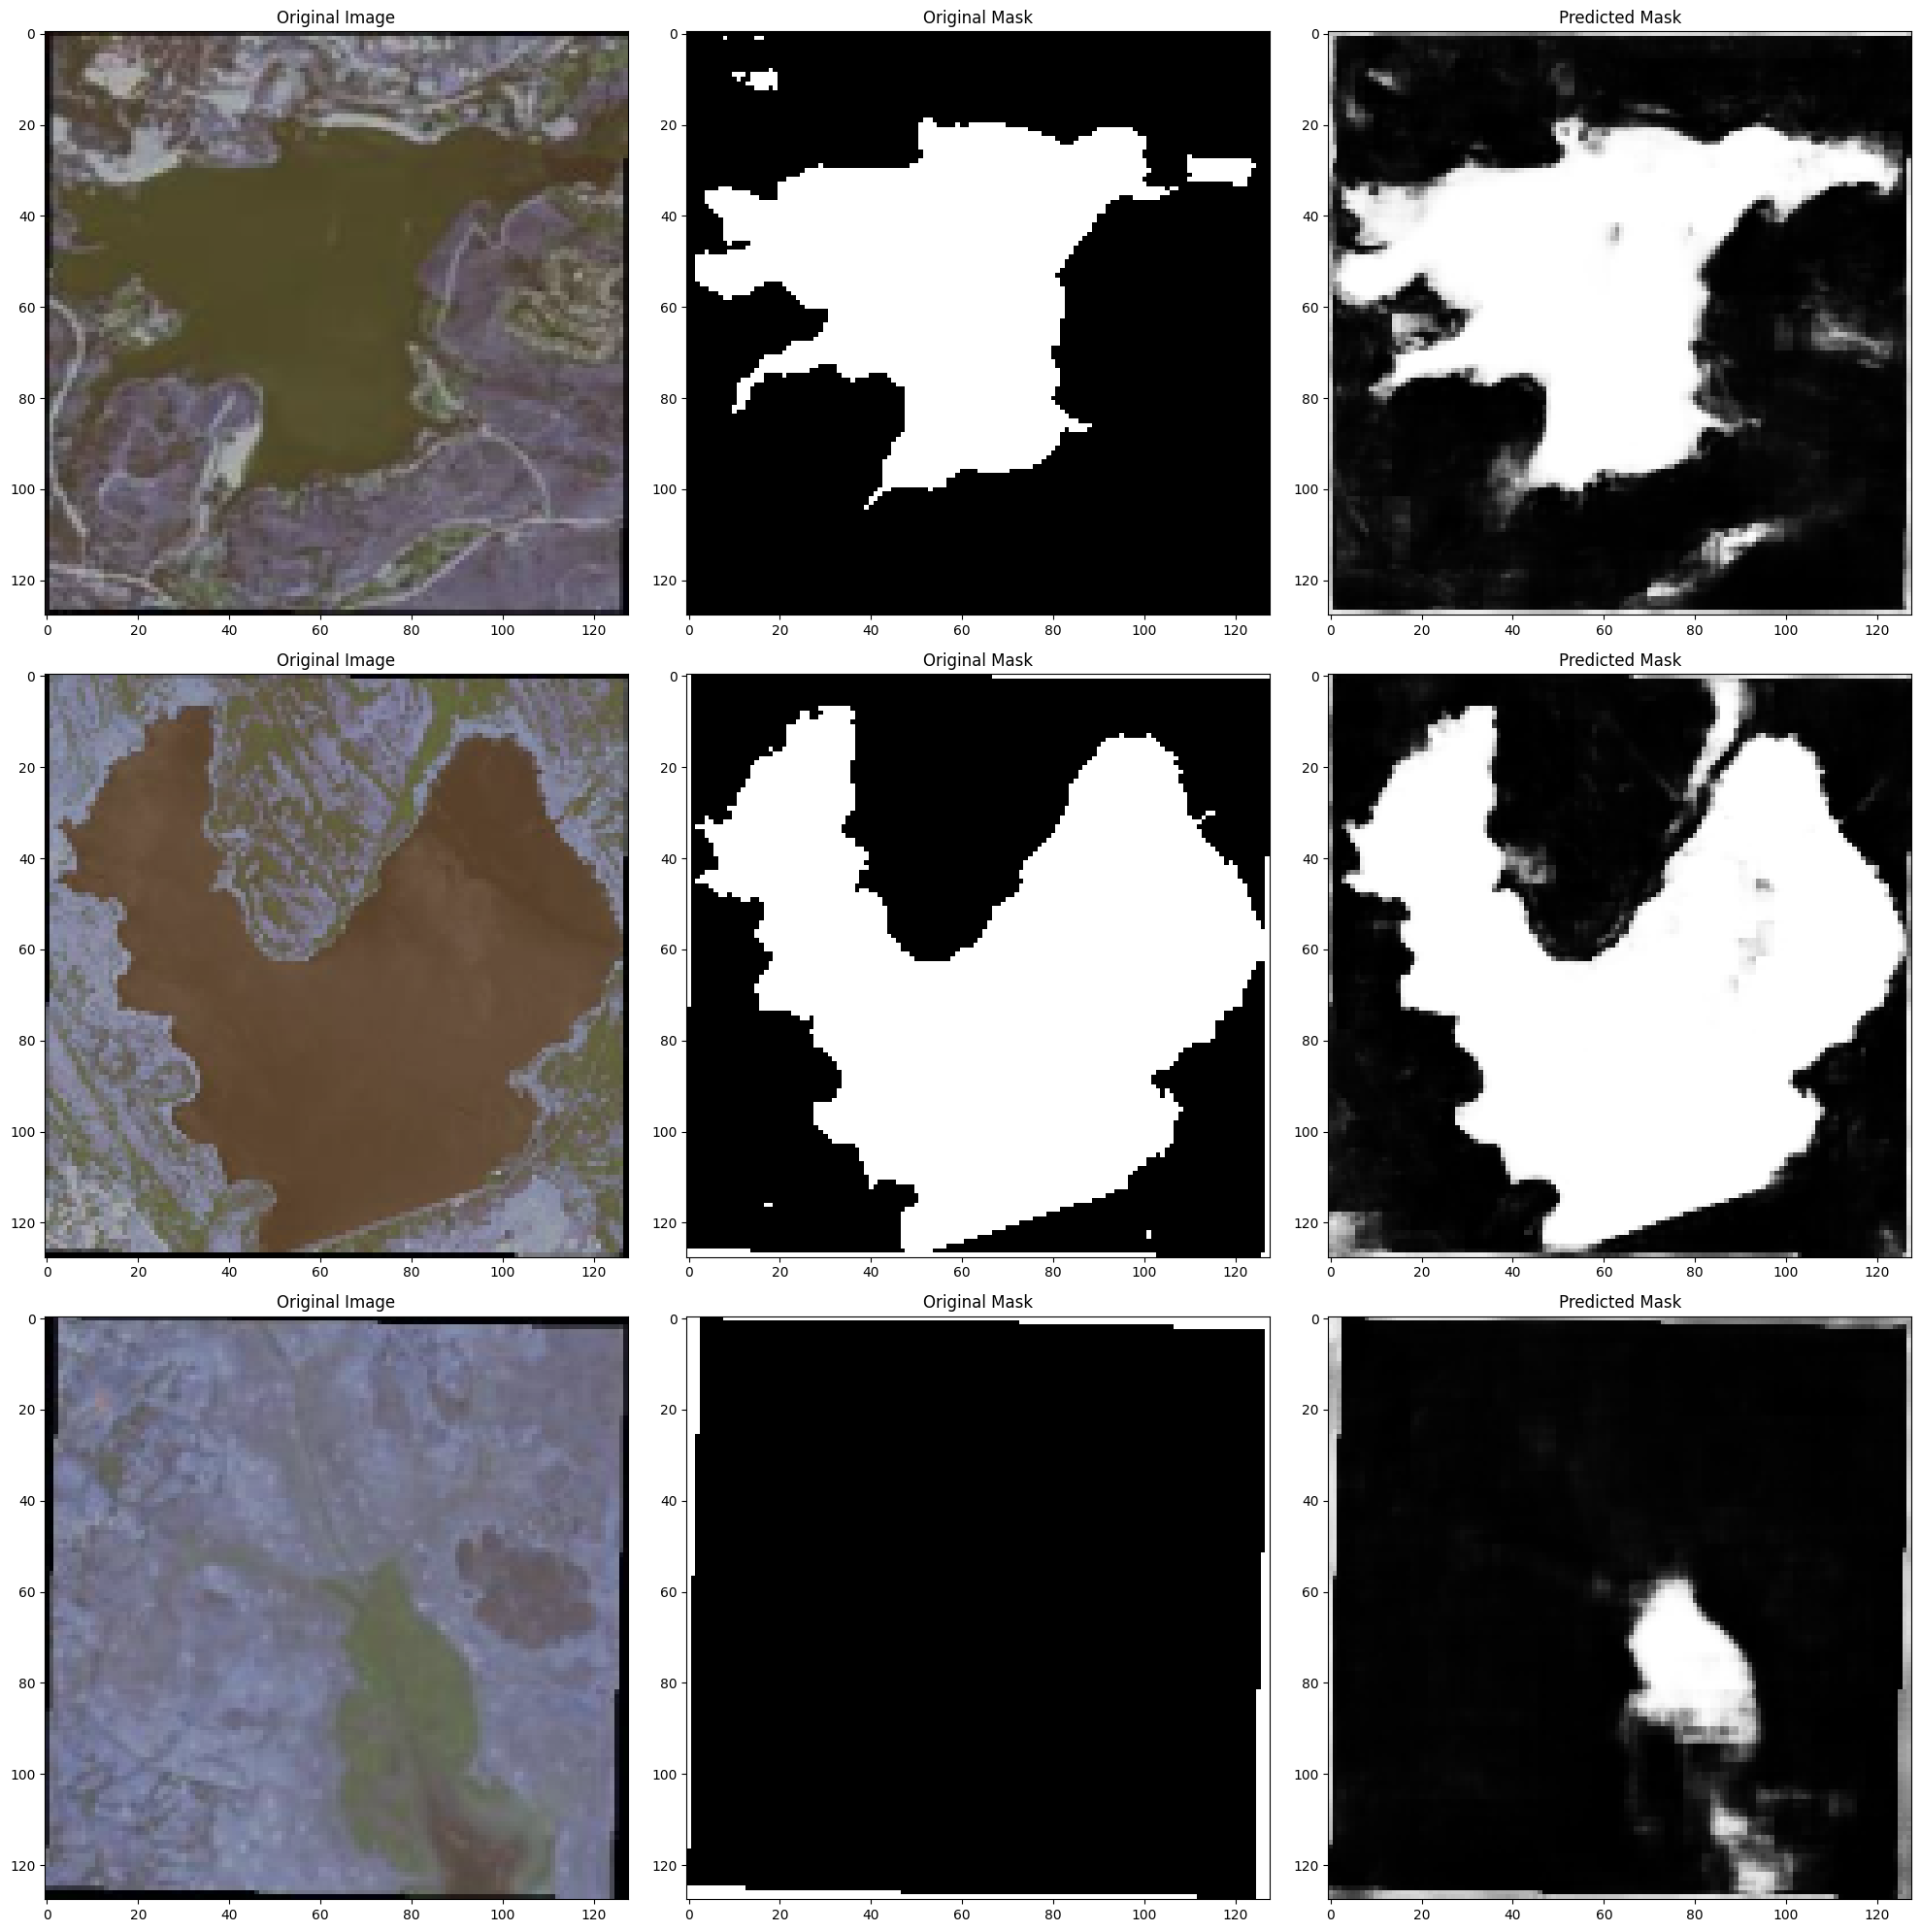

In [ ]:
# Visualize random original image, original mask, and predicted mask
fig, axes = plt.subplots(3, 3, figsize=(20, 20))

for i in range(3):
    rand_num = random.randint(0, len(X_test) - 1)
    original_img = X_test[rand_num]
    axes[i, 0].imshow(original_img)
    axes[i, 0].title.set_text('Original Image')

    original_mask = Y_test[rand_num].reshape(128, 128)
    axes[i, 1].imshow(original_mask, cmap='gray')
    axes[i, 1].title.set_text('Original Mask')

    original_img = np.expand_dims(original_img, axis=0)
    predicted_mask = model.predict(original_img).reshape(128, 128)
    axes[i, 2].imshow(predicted_mask, cmap='gray')
    axes[i, 2].title.set_text('Predicted Mask')

plt.tight_layout()
plt.show()
